# Estatísticas do Jogos da plataforma Alite

  - This file is part of  program Alite.
  - Copyright © 2023  Carlo Oliveira <carlo@nce.ufrj.br>.
  - [Labase](http://labase.selfip.org) - [NCE](http://portal.nce.ufrj.br) - [UFRJ](http://www.ufrj.br).
  - SPDX-License-Identifier: ([GNU General Public License v3.0 or later](https://www.gnu.org/licenses/gpl-3.0-standalone.html)).

## Version and configurations.

 This module retrieves data and plot statistics for the [Alite - Games](https://games.alite.selfip.org).

## [23.07](https://github.com/labase/data_edu/releases)

### Added

- Copy and fix plotting class from Alite Sevice (5).



## Recebe dados dos games de alite e converte para dataframe

In [85]:
import urllib.request, json
import pandas as pd
from pandas import DataFrame

class GameStats:
    def __init__(self, game_url='https://games.alite.selfip.org/score/games?oid={}'):
        self.game_url = game_url
        self.df: DataFrame = DataFrame()
        self.game_data = []
        self.count = 0

    def retrieve_games(self, player):
        """ Retrieve from remote source data for a given player

        :param player: Given player id; identification
        :return: None
        """
        with urllib.request.urlopen(self.game_url.format(player)) as urlp:
            self.game_data.extend(json.loads(urlp.read().decode()))

    def process_df(self):
        """ Shapes current dataframe to filter wisc and replace the column scorer

        :return:
        """
        def dt(g):
            k, l = g[0]["time"], g[-1]["time"]
            k, l = pd.to_datetime(k).tz_localize(None), pd.to_datetime(l).tz_localize(None)
            return pd.Timedelta(l-k, unit="min").seconds
        dfg_ = DataFrame(gd for gd in self.game_data if gd["scorer"])
        dfg_ = dfg_.loc[(dfg_['game'] == 'wcst') | (dfg_['game'] == 'game')]
        dfg_["jogadas"] = dfg_.scorer.apply(lambda x: len(x))
        dfg_["periodo"] = dfg_.scorer.apply(lambda x: dt(x))
        dfg_["game"] = dfg_.game.apply(lambda x: 'eica' if x == "game" else x)
        dfg_["name"] = dfg_.name.apply(lambda x: f"{n[0]} {n[1][:2]}." if len(n:=x.split()) >1  else x)
        dfx_ = dfg_.drop(columns=["scorer", "_id"], inplace=False).reset_index()
        dfo = dfx_.groupby(
             ['name','game'], as_index=False
         ).agg({'jogadas':'max', 'periodo':'max'}).reset_index()
        return dfo

    def person_load(self, person='https://games.alite.selfip.org/score/players'):
        """ Carrega as informações de dados a partir de um servidor num arcabouço.

        :param person: Url que endereça os dados necessários
        :return: None
        """
        import urllib.request
        import json
        from datetime import datetime
        import re
        then = datetime(2023, 6, 29)
        def new(g):
            play_date = pd.to_datetime(g["time"]).tz_localize(None)
            return play_date > then

        def get_oid(oid):
            return re.findall(r"'(.+?)'", oid)[0]
        with urllib.request.urlopen(person) as url:
            data = json.loads(url.read().decode())
            oids = [get_oid(gui["_id"]) for gui in data if new(gui)]
            _ = [self.retrieve_games(oid) for oid in oids]
        self.df = self.process_df()
        return self


gs = GameStats().person_load()
print(gs.df)
# _ = [print(g) for g in gs.game_data]

    index            name  game  jogadas  periodo
0       0   Cristiano Ro.  eica      270     1178
1       1          Dayane  eica      350     2105
2       2         Douglas  eica      619     2379
3       3        Fernando  eica      292     1098
4       4   Guilherme Ga.  eica      188     1466
5       5           Italo  eica      561     1741
6       6           Italo  wcst      129      750
7       7         Jessica  eica       78      606
8       8       Julia Al.  eica      232     1941
9       9       Julia Al.  wcst      129      540
10     10         Jéssica  wcst      129      486
11     11       Júlya Cu.  eica      157     1494
12     12          Kaique  eica      312     1611
13     13           Pedro  wcst      129      622
14     14  Thimberlly ke.  eica        2        9
15     15     Vanessa Vi.  eica      538     4107
16     16            Yuri  eica      424     1219
17     17            Yuri  wcst        1        0
18     18              eu  eica        1        0


## Plota dois subgraficos para indicar a permanência e as jogadas dos participantes nos games

<Figure size 1500x800 with 0 Axes>

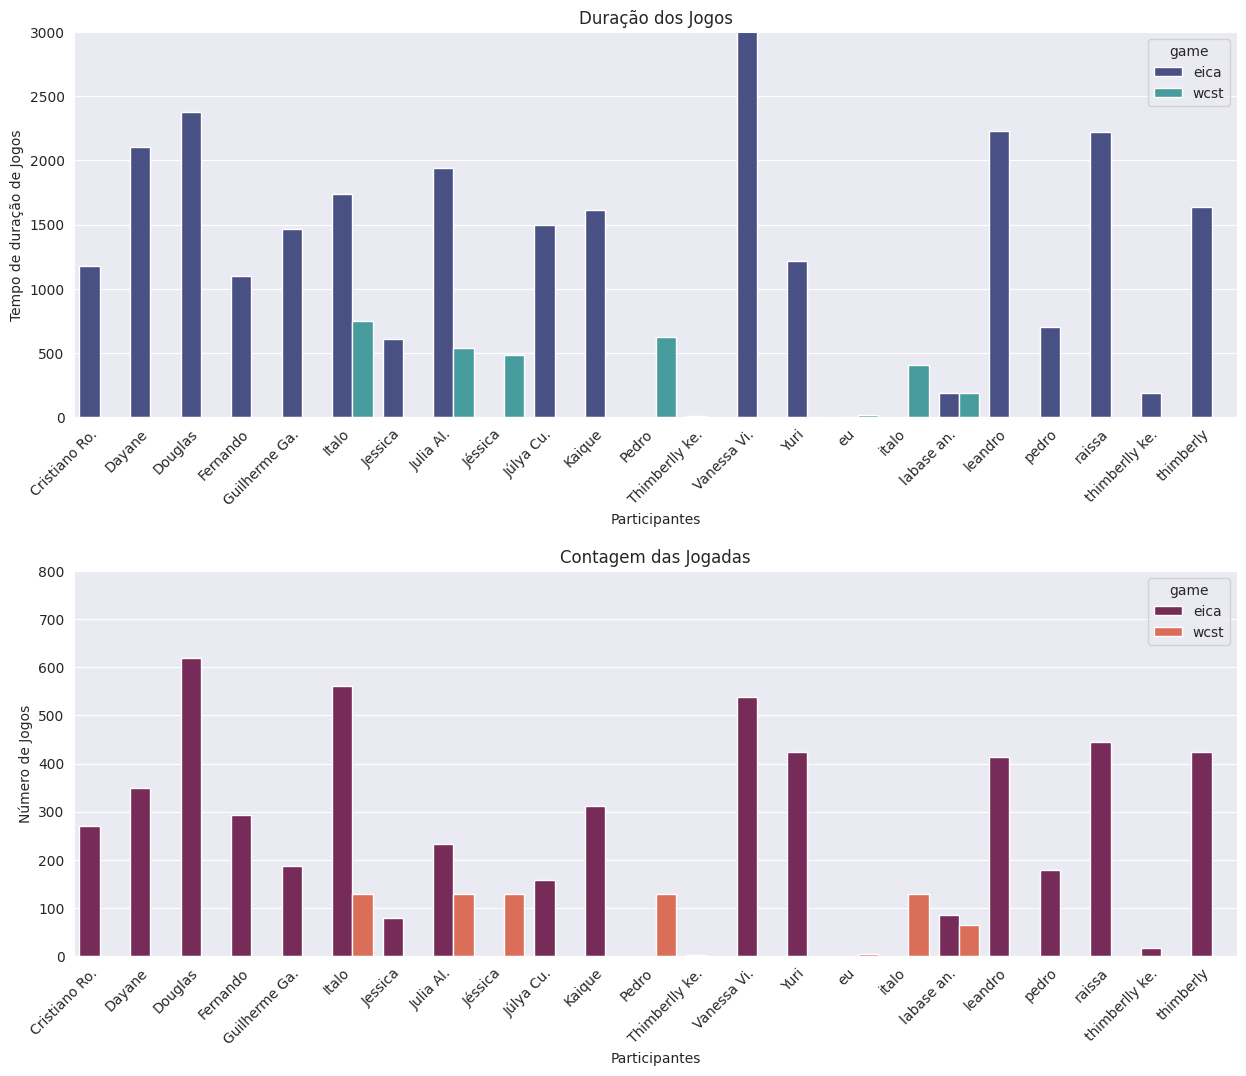

In [90]:
import seaborn as sns
from matplotlib import pyplot as plt
dfx = gs.df
_ = plt.figure(figsize=(15,8))
fig, (ax1, ax2) = plt.subplots(2)
fig.set_figheight(12)
fig.set_figwidth(15)
plt.subplots_adjust(hspace = 0.4)

chart = sns.barplot(data=dfx, x="name", y="periodo", hue="game", ax=ax1, palette="mako")
_ = chart.set(title='Duração dos Jogos', ylabel='Tempo de duração de Jogos', xlabel="Participantes", ylim=(0, 3000))
_ = chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

chart1 = sns.barplot(data=dfx, x="name", y="jogadas", hue="game", ax=ax2, palette="rocket")
_ = chart1.set(title='Contagem das Jogadas', ylabel='Número de Jogos', xlabel="Participantes", ylim=(0, 800))
_ = chart1.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
